In [1]:
import keras
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.models import load_model

Using TensorFlow backend.


در زیر دو تابع تعریف شده است اولی برای کشیدن لایه  میانی در دو بعد و دومی برای تولید شکل های 10 در 10 

In [3]:
def plot_latent(models,data,batch_size=128,model_name="vae_mnist"):
    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
    
def plot_fig():
    # display a 30x30 2D manifold of digits
    n = 10
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

در این بخش داده های مربوط به mnist

را می خوانیم و آنها را بین 0و1 اسکیل می کنیم .



In [4]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.reshape(x_train, [-1, x_train.shape[1] * x_train.shape[1]])
x_test = np.reshape(x_test, [-1, x_train.shape[1]])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

11493376/11490434 [==============================] - 1s 0us/step


در این قسمت یک انکودر یک لایه تعریف می کنیم که 512 نورون 

دارد سپس دو لایه خروجی به عنوان فضای latent 

این دو لایه هر کدام دو نورون دارند یکی برای میانگین ها و دیگری برای واریانس ها

In [5]:
inputs = Input(shape=(x_train.shape[1], ), name='encoder_input')
x1 = Dense(512, activation='relu')(inputs)
means = Dense(2, name='means')(x1)
vars = Dense(2, name='vars')(x1)

در این قسمت از میانگین ها و واریانس ها نمونه گیری می کنیم .
 تابعی تعریف شده که که دو ورودی میانگین ها و واریانس ها را می گیرد و یک خروجی تولید می کند . این خروجی وارد لایه دیکودر می شود تا تصویر مورد نظر ایجاد شود
  
  z = z_mean + sqrt(var) * epsilon

In [6]:
def sampling(args):
    means, vars = args
    batch = K.shape(means)[0]
    dim = K.int_shape(means)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return means + K.exp(0.5 * vars) * epsilon

z = Lambda(sampling, output_shape=(2,), name='z')([means, vars])

مدل انکودر را می سازیم

In [7]:
encoder = Model(inputs, [means, vars, z], name='encoder')

حال در این قسمت لازم است تا بخش دیکودر را بسازیم 
دیکودر هم مانند انکودر از یه لایه با 512 نورون تشکیل شده است سپس یک لایه خروجی داریم که از ابعاد تصویر ورودی است . در واقع می خواهیم تصویری با ابعاد همان تصویر ورودی را ایجاد کنیم

In [8]:
latent_inputs = Input(shape=(2,), name='z_sampling')
x2 = Dense(512, activation='relu')(latent_inputs)
outputs = Dense(x_train.shape[1] , activation='sigmoid')(x2)
decoder = Model(latent_inputs, outputs, name='decoder')

در این قسمت دو بخش دیکودر و انکودر را با هم ترکیب نموده و مدل نهایی را می سازیم

In [9]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

در این قسمت برای کامپایل مدل نهایی لازم است تا تابع لاس را تعریف کنیم 

VAE loss = mse_loss + kl_loss

In [13]:
loss = mse(inputs, outputs)
loss *= x_train.shape[1]
kl_loss = 1 + vars - K.square(means) - K.exp(vars)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


در این قسمت آموزش شبکه را انجام می دهیم 

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


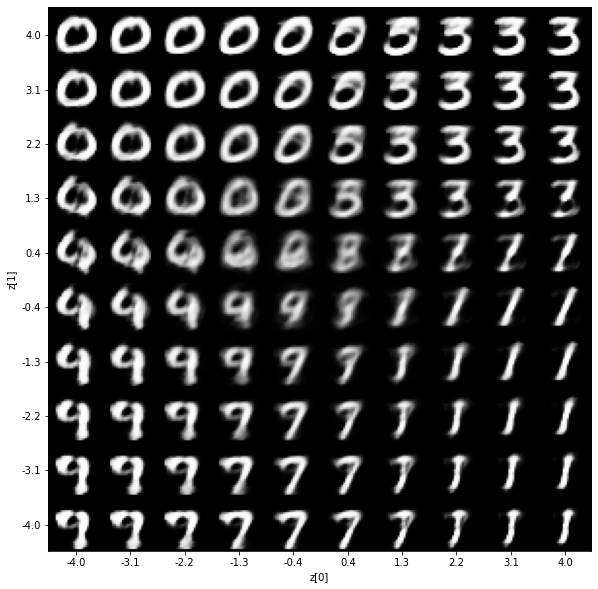

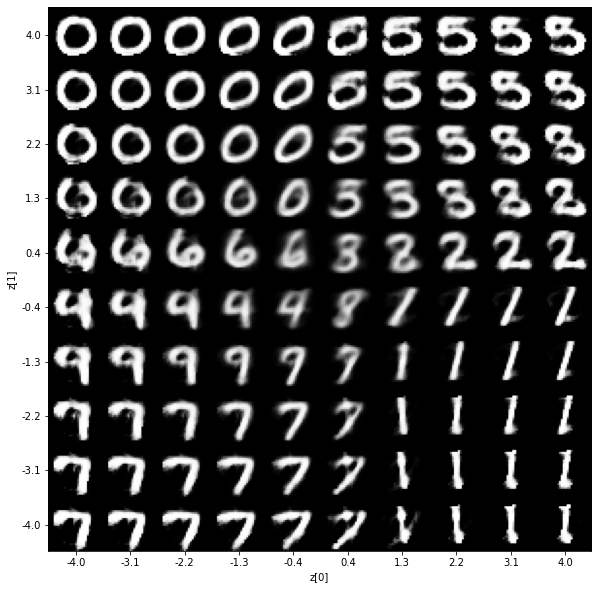

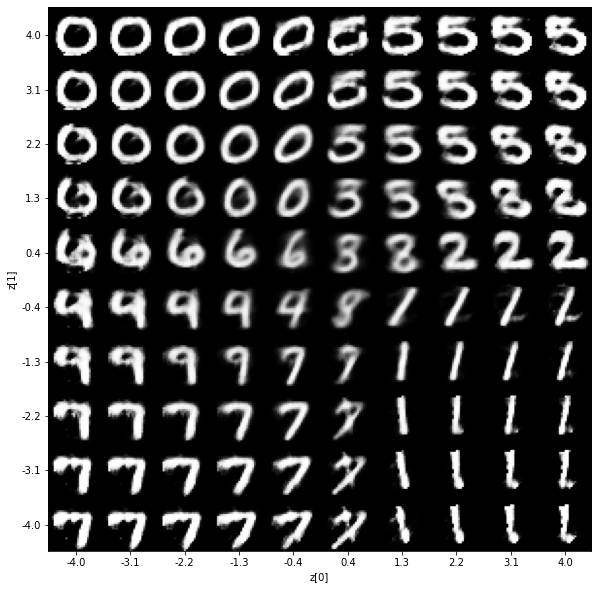

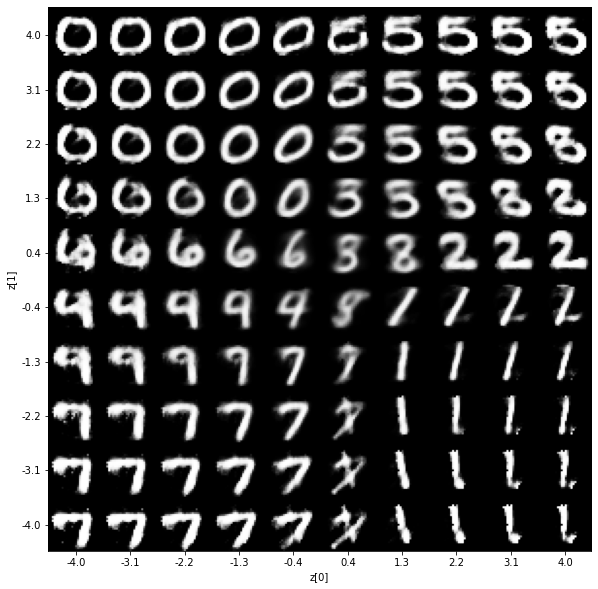

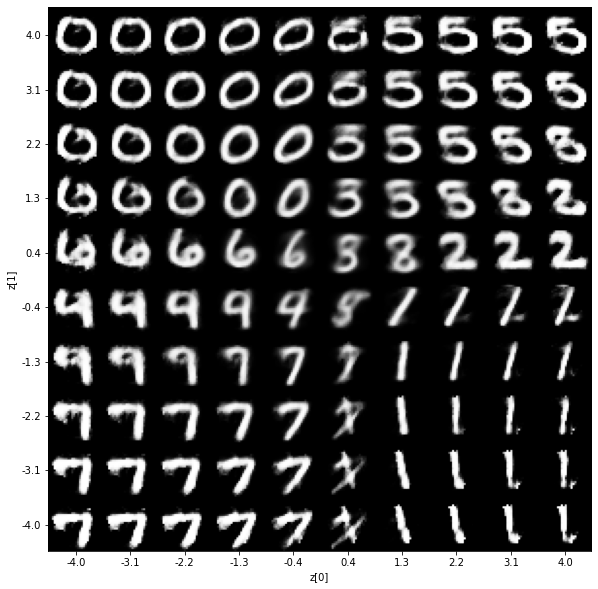

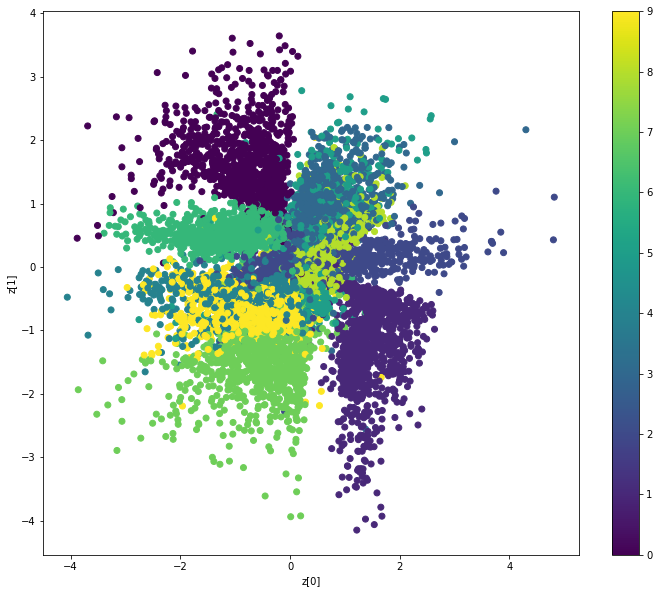

In [ ]:
epochs = 50
batch_size = 128
loss = []
for e in range(epochs):
    for i in range(len(x_train) // batch_size):
      X_batch = x_train[i*batch_size:(i+1)*batch_size]
      loss.append(vae.fit(x=X_batch,verbose=0))
    if(e%10 == 0):
      plot_fig()
plot_latent((encoder, decoder),(x_test,y_test),batch_size=128,model_name="vae_mlp")

کشیدن تابع لاس

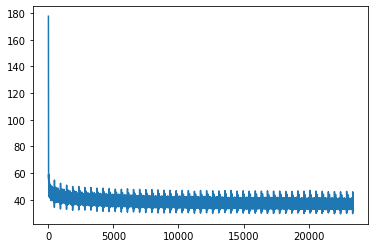

In [ ]:
l=[]
for i in range(len(loss)):
  l.append(loss[i].history['loss'])
plt.plot(l)

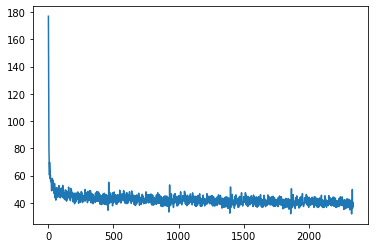

In [ ]:
l=[]
for i in range(len(loss)):
  l.append(loss[i].history['loss'])
plt.plot(l)